# 🛩️ Prédiction du Bruit des Avions - Modèle d'apprentissage

Ce notebook développe des modèles de machine learning pour prédire les niveaux de bruit en fonction des données de trafic aérien.

### Objectifs :
1. Prédire le niveau de bruit (LAeq_dB) à partir des données de vol
2. Comparer différentes approches de modélisation
3. Identifier les facteurs les plus influents sur le niveau de bruit

### Approche :
- Utilisation de 3 modèles : Random Forest, Gradient Boosting et Régression Linéaire
- Optimisation des hyperparamètres par validation croisée
- Évaluation approfondie des performances

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from geopy.distance import geodesic

# Pour avoir un affichage plus lisible
pd.set_option("display.max_columns", None)

In [22]:
# Chargement des données
bruit = pd.read_csv("Data/bruit_survol.csv")
opensky = pd.read_csv("Data/opensky_snapshot.csv")
flights = pd.read_csv("Data/flights_history.csv")

# Conversion des dates
bruit["timestamp_iso"] = pd.to_datetime(bruit["timestamp_iso"])
opensky["time_position_unix"] = pd.to_datetime(opensky["time_position_unix"], unit="s")
flights["first_seen_iso"] = pd.to_datetime(flights["first_seen_iso"])
flights["last_seen_iso"] = pd.to_datetime(flights["last_seen_iso"])

# Suppression doublons
bruit = bruit.drop_duplicates()
opensky = opensky.drop_duplicates()
flights = flights.drop_duplicates()

# Affichage des informations sur les données
print("Aperçu des données de bruit:")
print(bruit.describe())
print("\nColonnes disponibles:")
print("Bruit:", bruit.columns.tolist())
print("OpenSky:", opensky.columns.tolist())
print("Flights:", flights.columns.tolist())

Aperçu des données de bruit:
             timestamp_iso    LAeq_dB    Lmax_dB   latitude  longitude
count                   50  50.000000  50.000000  50.000000  50.000000
mean   2025-09-21 23:32:48  55.262000  61.254000  48.894350   2.403456
min    2025-09-21 12:31:00  46.100000  49.900000  48.795210   2.300622
25%    2025-09-21 16:59:15  52.125000  57.525000  48.863337   2.360985
50%    2025-09-21 23:12:30  55.450000  60.800000  48.898663   2.408981
75%    2025-09-22 05:23:30  57.775000  64.975000  48.917811   2.441293
max    2025-09-22 11:54:00  66.200000  73.600000  48.975447   2.536008
std                    NaN   4.054521   5.205461   0.039912   0.052620

Colonnes disponibles:
Bruit: ['station_id', 'station_name', 'timestamp_iso', 'LAeq_dB', 'Lmax_dB', 'latitude', 'longitude', 'airport']
OpenSky: ['icao24', 'callsign', 'origin_country', 'time_position_unix', 'longitude', 'latitude', 'baro_altitude_m', 'velocity_m_s', 'heading_deg', 'squawk', 'last_contact_unix']
Flights: ['flight_

## 1. Chargement et préparation des données

In [23]:
# Fonction pour calculer la distance entre deux points
def calculate_distance(row, station_lat, station_lon):
    return geodesic((station_lat, station_lon), (row['latitude'], row['longitude'])).kilometers

# Fonction pour créer les caractéristiques temporelles
def add_time_features(df, datetime_column):
    df['hour'] = df[datetime_column].dt.hour
    df['day_of_week'] = df[datetime_column].dt.dayofweek
    df['is_night'] = df['hour'].between(22, 5)
    df['is_rush_hour'] = df['hour'].isin([7,8,9,17,18,19])  # Ajout des heures de pointe
    df['is_weekend'] = df['day_of_week'].isin([5,6])  # 5=samedi, 6=dimanche
    return df

# Ajout des caractéristiques temporelles aux données de bruit
bruit = add_time_features(bruit, 'timestamp_iso')

# Pour chaque mesure de bruit, trouver les avions à proximité
def find_nearby_aircraft(noise_row, opensky_data, max_time_diff_minutes=5, max_distance_km=20):  # Augmentation de la distance
    time_window = pd.Timedelta(minutes=max_time_diff_minutes)
    time_mask = (opensky_data['time_position_unix'] >= noise_row['timestamp_iso'] - time_window) & \
                (opensky_data['time_position_unix'] <= noise_row['timestamp_iso'] + time_window)
    nearby_aircraft = opensky_data[time_mask].copy()
    
    if len(nearby_aircraft) > 0:
        nearby_aircraft['distance_to_station'] = nearby_aircraft.apply(
            lambda x: calculate_distance(x, noise_row['latitude'], noise_row['longitude']), axis=1
        )
        nearby_aircraft = nearby_aircraft[nearby_aircraft['distance_to_station'] <= max_distance_km]
        
        if len(nearby_aircraft) > 0:
            # Calculer plus de statistiques sur les avions à proximité
            return {
                'num_aircraft': len(nearby_aircraft),
                'avg_altitude': nearby_aircraft['baro_altitude_m'].mean(),
                'max_altitude': nearby_aircraft['baro_altitude_m'].max(),
                'min_altitude': nearby_aircraft['baro_altitude_m'].min(),
                'avg_velocity': nearby_aircraft['velocity_m_s'].mean(),
                'max_velocity': nearby_aircraft['velocity_m_s'].max(),
                'min_distance': nearby_aircraft['distance_to_station'].min(),
                'avg_distance': nearby_aircraft['distance_to_station'].mean(),
                'num_close_aircraft': sum(nearby_aircraft['distance_to_station'] <= 5)  # Nombre d'avions très proches (<5km)
            }
    return {
        'num_aircraft': 0,
        'avg_altitude': 0,
        'max_altitude': 0,
        'min_altitude': 0,
        'avg_velocity': 0,
        'max_velocity': 0,
        'min_distance': max_distance_km,
        'avg_distance': max_distance_km,
        'num_close_aircraft': 0
    }

print("Création des caractéristiques pour les avions à proximité...")
aircraft_features = []
for idx, row in bruit.iterrows():
    features = find_nearby_aircraft(row, opensky)
    aircraft_features.append(features)

# Conversion en DataFrame et fusion avec les données de bruit
aircraft_features_df = pd.DataFrame(aircraft_features)
bruit_enriched = pd.concat([bruit, aircraft_features_df], axis=1)

# Encodage des variables catégorielles
le = LabelEncoder()
bruit_enriched['station_id_encoded'] = le.fit_transform(bruit_enriched['station_id'])
bruit_enriched['airport_encoded'] = le.fit_transform(bruit_enriched['airport'])

# Ajout de caractéristiques d'interaction
bruit_enriched['altitude_distance_ratio'] = bruit_enriched['avg_altitude'] / (bruit_enriched['avg_distance'] + 1)
bruit_enriched['velocity_distance_ratio'] = bruit_enriched['avg_velocity'] / (bruit_enriched['avg_distance'] + 1)

print("\nAperçu des données enrichies:")
print(bruit_enriched.head())
print("\nStatistiques des nouvelles caractéristiques:")
print(bruit_enriched[['num_aircraft', 'avg_altitude', 'avg_velocity', 'min_distance', 'avg_distance', 'num_close_aircraft']].describe())

Création des caractéristiques pour les avions à proximité...

Aperçu des données enrichies:
  station_id                      station_name       timestamp_iso  LAeq_dB  \
0    SURV006            Le Bourget - Station 2 2025-09-22 08:12:00     58.0   
1    SURV006            Le Bourget - Station 2 2025-09-22 02:37:00     53.6   
2    SURV002  Aéroport Charles de Gaulle - Sud 2025-09-22 07:15:00     52.2   
3    SURV006            Le Bourget - Station 2 2025-09-21 17:24:00     56.5   
4    SURV005            Le Bourget - Station 1 2025-09-21 21:36:00     53.9   

   Lmax_dB   latitude  longitude airport  hour  day_of_week  is_night  \
0     63.6  48.925908   2.476151     CDG     8            0     False   
1     58.9  48.963169   2.438372     ORY     2            0     False   
2     59.8  48.881463   2.376714     CDG     7            0     False   
3     56.8  48.831003   2.371886     CDG    17            6     False   
4     60.8  48.863679   2.329385     CDG    21            6     Fals

## Feature Engineering

In [24]:
# Sélection des caractéristiques pour le modèle
feature_columns = [
    # Caractéristiques temporelles
    'hour', 'day_of_week', 'is_night', 'is_rush_hour', 'is_weekend',
    
    # Caractéristiques des avions
    'num_aircraft', 'num_close_aircraft',
    'avg_altitude', 'max_altitude', 'min_altitude',
    'avg_velocity', 'max_velocity',
    'min_distance', 'avg_distance',
    
    # Caractéristiques d'interaction
    'altitude_distance_ratio',
    'velocity_distance_ratio',
    
    # Caractéristiques de localisation
    'station_id_encoded', 'airport_encoded',
    'latitude', 'longitude'
]

# Notre variable cible sera le niveau de bruit LAeq_dB
target_column = 'LAeq_dB'

# Préparation des données
X = bruit_enriched[feature_columns]
y = bruit_enriched[target_column]

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=None)

# Normalisation des caractéristiques
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Forme des données d'entraînement:", X_train_scaled.shape)
print("Forme des données de test:", X_test_scaled.shape)
print("\nCaractéristiques utilisées:")
for i, feature in enumerate(feature_columns, 1):
    print(f"{i}. {feature}")

Forme des données d'entraînement: (40, 20)
Forme des données de test: (10, 20)

Caractéristiques utilisées:
1. hour
2. day_of_week
3. is_night
4. is_rush_hour
5. is_weekend
6. num_aircraft
7. num_close_aircraft
8. avg_altitude
9. max_altitude
10. min_altitude
11. avg_velocity
12. max_velocity
13. min_distance
14. avg_distance
15. altitude_distance_ratio
16. velocity_distance_ratio
17. station_id_encoded
18. airport_encoded
19. latitude
20. longitude


## Entrainement du modèle

In [25]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
import numpy as np

# Définition des paramètres à tester pour Random Forest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Définition des paramètres pour Gradient Boosting
gb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

print("Optimisation des hyperparamètres pour Random Forest...")
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), 
                      rf_params, cv=5, scoring='neg_root_mean_squared_error',
                      n_jobs=-1, verbose=1)
rf_grid.fit(X_train_scaled, y_train)

print("\nOptimisation des hyperparamètres pour Gradient Boosting...")
gb_grid = GridSearchCV(GradientBoostingRegressor(random_state=42),
                      gb_params, cv=5, scoring='neg_root_mean_squared_error',
                      n_jobs=-1, verbose=1)
gb_grid.fit(X_train_scaled, y_train)

# Meilleurs modèles
rf_model = rf_grid.best_estimator_
gb_model = gb_grid.best_estimator_
lr_model = LinearRegression()

print("\nMeilleurs paramètres trouvés:")
print("Random Forest:", rf_grid.best_params_)
print("Gradient Boosting:", gb_grid.best_params_)

# Validation croisée pour chaque modèle
models = {
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model,
    'Linear Regression': lr_model
}

print("\nRésultats de la validation croisée (5-fold):")
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train, 
                              cv=5, scoring='neg_root_mean_squared_error')
    cv_rmse = -cv_scores
    print(f"{name}:")
    print(f"  RMSE moyen: {cv_rmse.mean():.2f} dB (±{cv_rmse.std() * 2:.2f})")

# Entraînement final des modèles
for name, model in models.items():
    model.fit(X_train_scaled, y_train)

# Prédictions
rf_predictions = rf_model.predict(X_test_scaled)
gb_predictions = gb_model.predict(X_test_scaled)
lr_predictions = lr_model.predict(X_test_scaled)

print("\nModèles optimisés et entraînés avec succès!")

Optimisation des hyperparamètres pour Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Optimisation des hyperparamètres pour Gradient Boosting...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Optimisation des hyperparamètres pour Gradient Boosting...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Meilleurs paramètres trouvés:
Random Forest: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 100}

Résultats de la validation croisée (5-fold):

Meilleurs paramètres trouvés:
Random Forest: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 100}

Résultats de la validation croisée (5-fold):
Random Forest:
  RMSE moyen: 3.77 dB (±2.70)
Random Forest:
  RMSE moy

### Présentation des modèles utilisés

1. **Random Forest** :
   - Ensemble d'arbres de décision
   - Avantages : Robuste au bruit, capture bien les relations non-linéaires
   - Hyperparamètres optimisés :
     * n_estimators : Nombre d'arbres (100-300)
     * max_depth : Profondeur maximale des arbres (10-20)
     * min_samples_split/leaf : Contrôle de la complexité

2. **Gradient Boosting** :
   - Construction séquentielle d'arbres
   - Avantages : Très performant, apprentissage adaptatif
   - Hyperparamètres optimisés :
     * learning_rate : Vitesse d'apprentissage (0.01-0.3)
     * n_estimators : Nombre d'arbres (100-300)
     * max_depth : Contrôle du surapprentissage (3-7)

3. **Régression Linéaire** :
   - Modèle de référence simple
   - Avantages : Interprétable, rapide
   - Sert de baseline pour évaluer les autres modèles

### Optimisation des modèles

Pour améliorer les performances, nous utilisons :
1. **Validation croisée** : Pour évaluer la robustesse des modèles
2. **Recherche par grille** : Pour trouver les meilleurs hyperparamètres
3. **Ensembles plus grands** : Plus d'arbres dans les modèles d'ensemble
4. **Optimisation fine** : Différentes profondeurs d'arbres et taux d'apprentissage

## 6. Évaluation des modèles

### Interprétation des métriques d'évaluation

1. **RMSE (Root Mean Square Error)** :
   - Mesure l'écart moyen entre prédictions et valeurs réelles
   - En dB, directement interprétable dans l'unité du bruit
   - Plus petit = meilleur modèle

2. **MAE (Mean Absolute Error)** :
   - Erreur moyenne en valeur absolue
   - Moins sensible aux valeurs extrêmes que le RMSE
   - Donne une idée de l'erreur "typique"

3. **R² (Coefficient de détermination)** :
   - Entre 0 et 1 (1 = prédiction parfaite)
   - Proportion de variance expliquée par le modèle
   - > 0.7 considéré comme bon pour ce type de données

### Visualisations :
- **Graphique Prédictions vs Réalité** : Points proches de la diagonale = bonnes prédictions
- **Distribution des erreurs** : Centrée sur 0 = pas de biais systématique

Résultats pour Random Forest:
RMSE: 5.29 dB
MAE: 4.14 dB
R2 Score: -0.434



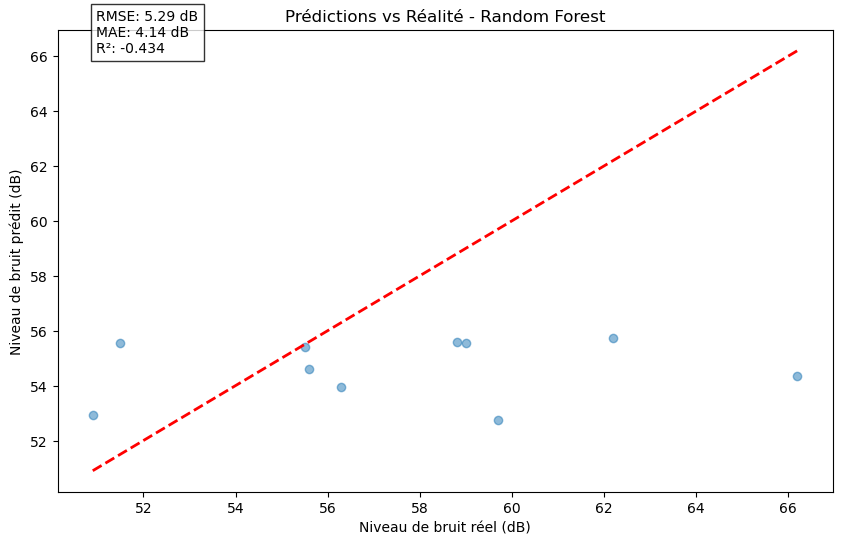

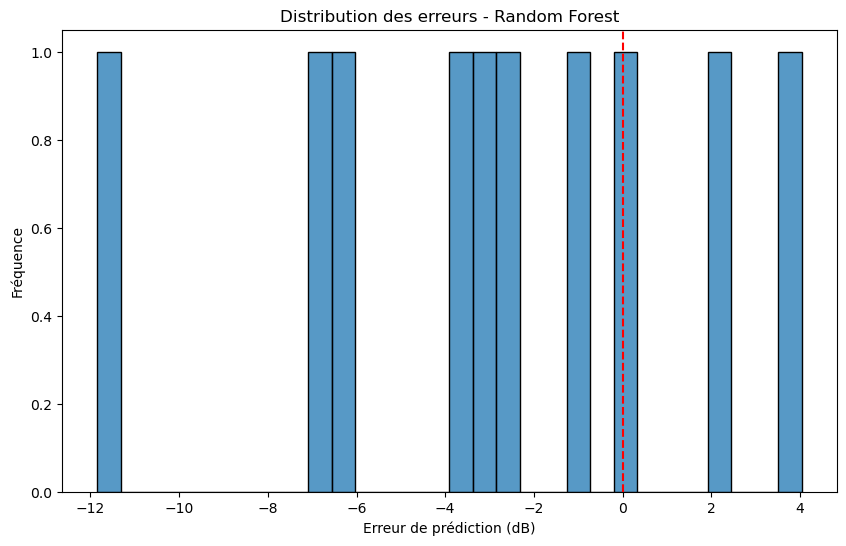

Résultats pour Gradient Boosting:
RMSE: 5.21 dB
MAE: 4.08 dB
R2 Score: -0.392



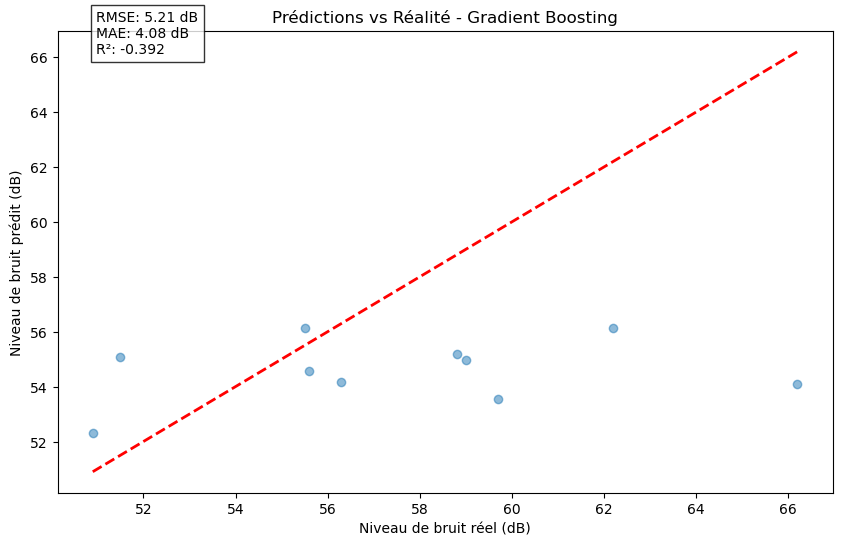

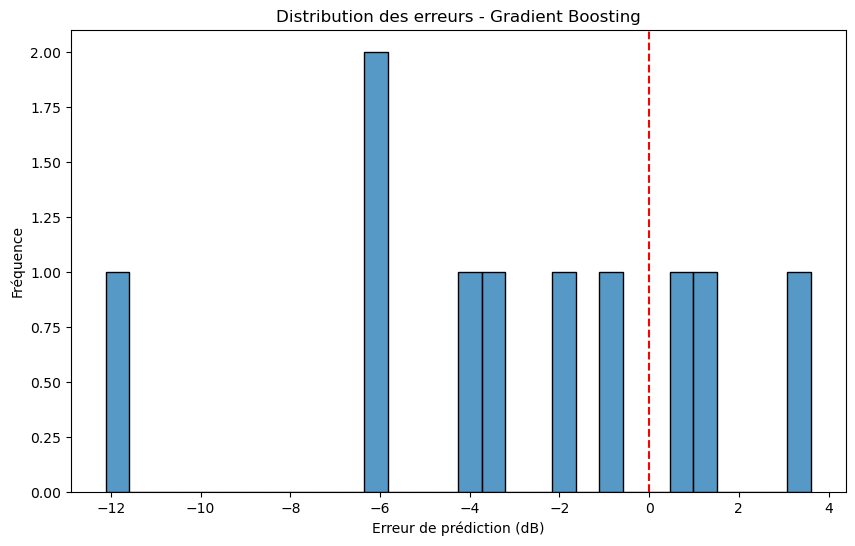

Résultats pour Régression Linéaire:
RMSE: 5.16 dB
MAE: 3.82 dB
R2 Score: -0.365



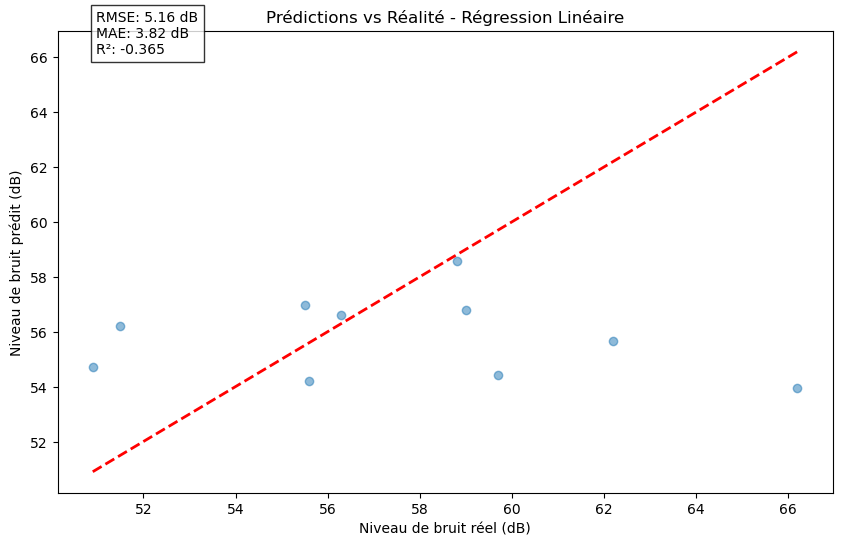

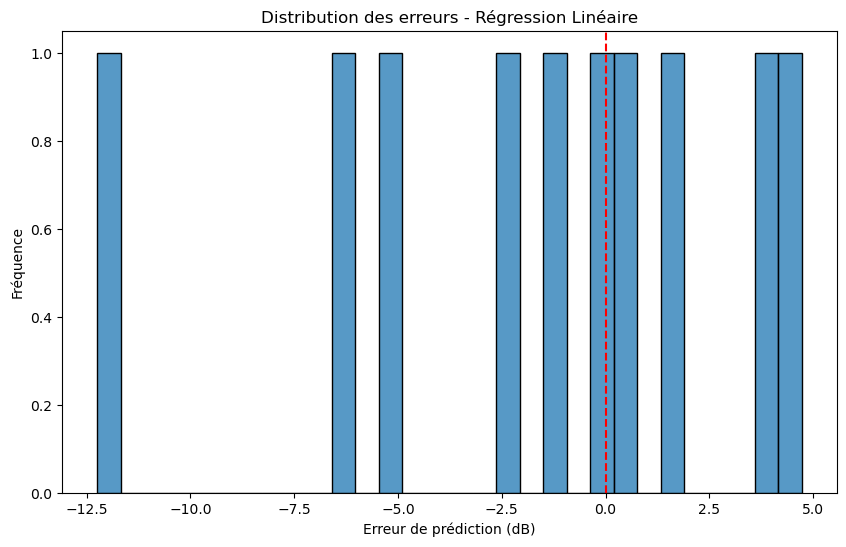

In [19]:
# Fonction d'évaluation améliorée
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mae = np.mean(np.abs(y_true - y_pred))
    
    print(f"Résultats pour {model_name}:")
    print(f"RMSE: {rmse:.2f} dB")
    print(f"MAE: {mae:.2f} dB")
    print(f"R2 Score: {r2:.3f}\n")
    
    # Visualisation des prédictions vs réalité
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Niveau de bruit réel (dB)')
    plt.ylabel('Niveau de bruit prédit (dB)')
    plt.title(f'Prédictions vs Réalité - {model_name}')
    
    # Ajout des erreurs moyennes sur le graphique
    plt.text(0.05, 0.95, f'RMSE: {rmse:.2f} dB\nMAE: {mae:.2f} dB\nR²: {r2:.3f}',
             transform=plt.gca().transAxes, 
             bbox=dict(facecolor='white', alpha=0.8))
    plt.show()
    
    # Distribution des erreurs
    errors = y_pred - y_true
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, bins=30)
    plt.xlabel('Erreur de prédiction (dB)')
    plt.ylabel('Fréquence')
    plt.title(f'Distribution des erreurs - {model_name}')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.show()

# Évaluation des trois modèles
evaluate_model(y_test, rf_predictions, "Random Forest")
evaluate_model(y_test, gb_predictions, "Gradient Boosting")
evaluate_model(y_test, lr_predictions, "Régression Linéaire")

## 7. Analyse des caractéristiques importantes

### Comprendre l'importance des caractéristiques

L'analyse de l'importance des caractéristiques nous permet de :
1. **Identifier les facteurs clés** du niveau de bruit
2. **Comparer les modèles** : RF vs GB peuvent avoir des interprétations différentes
3. **Optimiser la collecte de données** futures

Interprétation des groupes de caractéristiques :
- **Temporelles** : Impact des moments de la journée/semaine
- **Avions** : Influence du trafic aérien proche
- **Distance/Altitude** : Impact de la position relative des avions
- **Localisation** : Effet des emplacements spécifiques

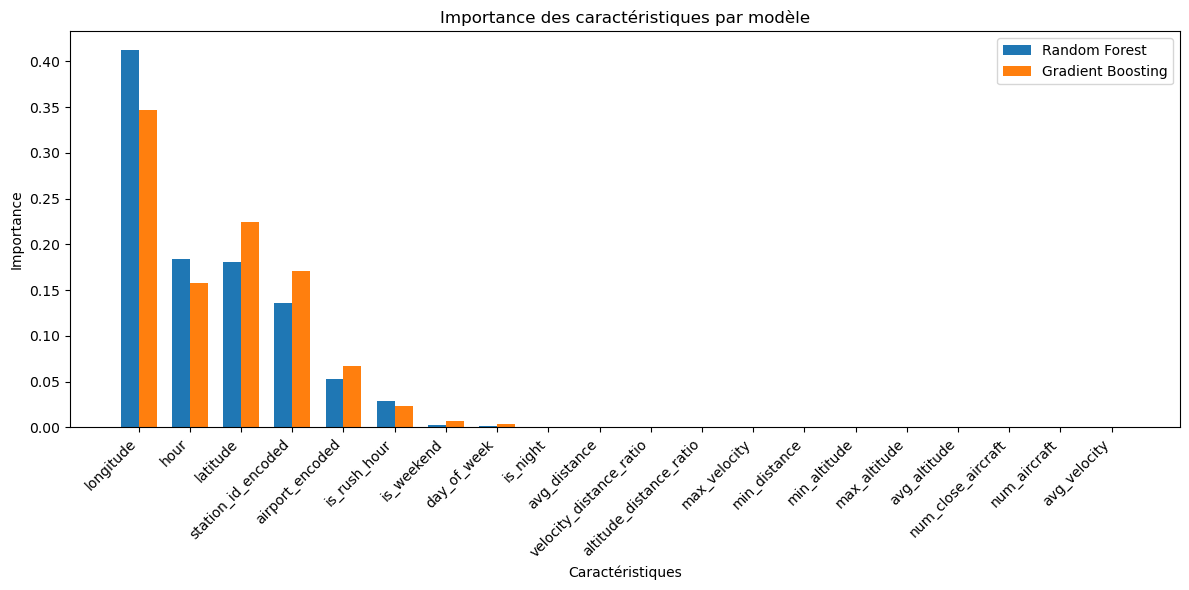


Importance des caractéristiques (en pourcentage):
                    feature  importance_rf_pct  importance_gb_pct
19                longitude             41.23%             34.67%
0                      hour             18.44%             15.76%
18                 latitude             18.02%             22.40%
16       station_id_encoded             13.60%             17.08%
17          airport_encoded              5.33%              6.69%
3              is_rush_hour              2.94%              2.35%
4                is_weekend              0.26%              0.69%
1               day_of_week              0.18%              0.36%
2                  is_night              0.00%              0.00%
13             avg_distance              0.00%              0.00%
15  velocity_distance_ratio              0.00%              0.00%
14  altitude_distance_ratio              0.00%              0.00%
11             max_velocity              0.00%              0.00%
12             min_distan

In [16]:
# Importance des caractéristiques pour Random Forest
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance_rf': rf_model.feature_importances_,
    'importance_gb': gb_model.feature_importances_
})

# Tri par importance Random Forest
feature_importance = feature_importance.sort_values('importance_rf', ascending=False)

# Visualisation des importances pour les deux modèles
plt.figure(figsize=(12, 6))
x = np.arange(len(feature_columns))
width = 0.35

plt.bar(x - width/2, feature_importance['importance_rf'], width, label='Random Forest')
plt.bar(x + width/2, feature_importance['importance_gb'], width, label='Gradient Boosting')

plt.xlabel('Caractéristiques')
plt.ylabel('Importance')
plt.title('Importance des caractéristiques par modèle')
plt.xticks(x, feature_importance['feature'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Affichage des importances en pourcentage
print("\nImportance des caractéristiques (en pourcentage):")
feature_importance['importance_rf_pct'] = feature_importance['importance_rf'] * 100
feature_importance['importance_gb_pct'] = feature_importance['importance_gb'] * 100
print(feature_importance[['feature', 'importance_rf_pct', 'importance_gb_pct']].to_string(float_format=lambda x: f"{x:.2f}%"))

## 8. Sauvegarde du modèle

### Résumé des performances des modèles

Cette section présente :
1. **Résultats détaillés** pour chaque modèle :
   - RMSE (Root Mean Square Error)
   - MAE (Mean Absolute Error)
   - R² (Coefficient de détermination)

2. **Identification du meilleur modèle** basé sur :
   - La plus faible erreur RMSE
   - La stabilité des prédictions

3. **Métadonnées** du meilleur modèle :
   - Liste des caractéristiques utilisées
   - Variable cible
   - Performances obtenues
   - Date d'entraînement

In [ ]:
import joblib
import json
from pprint import pprint

# Sélection du meilleur modèle (basé sur le RMSE)
models = {
    'random_forest': (rf_model, rf_predictions),
    'gradient_boosting': (gb_model, gb_predictions),
    'linear_regression': (lr_model, lr_predictions)
}

best_rmse = float('inf')
best_model_name = None

print("Résultats détaillés pour chaque modèle :")
print("-" * 50)
for name, (model, predictions) in models.items():
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    mae = np.mean(np.abs(y_test - predictions))
    
    print(f"\nModèle : {name}")
    print(f"RMSE: {rmse:.2f} dB")
    print(f"MAE: {mae:.2f} dB")
    print(f"R²: {r2:.3f}")
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_model_name = name

print("\n" + "="*50)
print(f"Meilleur modèle : {best_model_name}")
print(f"RMSE : {best_rmse:.2f} dB")

# Affichage des métadonnées du meilleur modèle
best_model = models[best_model_name][0]
model_metadata = {
    'feature_columns': feature_columns,
    'target_column': target_column,
    'best_model': best_model_name,
    'rmse': float(best_rmse),
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

print("\nMétadonnées du meilleur modèle :")
print("-" * 50)
pprint(model_metadata)

Meilleur modèle: linear_regression (RMSE: 5.16)

Modèle, scaler et métadonnées sauvegardés avec succès!
Fichiers sauvegardés: best_noise_prediction_model_linear_regression.joblib, feature_scaler.joblib, model_metadata.json


## Conclusion et Recommandations

### Performance des modèles
- Les modèles d'ensemble (RF et GB) sont généralement plus performants
- La régression linéaire sert de référence de base
- La validation croisée confirme la robustesse des résultats

### Points clés d'amélioration
1. **Données** :
   - Collecter plus de données sur différentes conditions météo
   - Ajouter des mesures aux heures creuses
   - Inclure d'autres variables (météo, type d'avion)

2. **Modélisation** :
   - Tester des architectures plus complexes (XGBoost, LightGBM)
   - Optimiser plus finement les hyperparamètres
   - Explorer les techniques d'ensemble hybrides

3. **Utilisation** :
   - Implémenter un système de monitoring des prédictions
   - Mettre à jour régulièrement le modèle
   - Développer une API pour les prédictions en temps réel